<a href="https://colab.research.google.com/github/Vyshnavi153/Applied-NLP/blob/main/Vyshnavi_Daka_HW4A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <Font color = 'indianred'>**1. Set Environment** </font>

In [1]:
import sys
# Importing PyTorch library for tensor computations and neural network modules
import torch
import torch.nn as nn


# For working with textual data vocabularies and for displaying model summaries
from torchtext.vocab import vocab
#from torchinfo import summary


# General-purpose Python libraries for random number generation and numerical operations
import random
import numpy as np
import pandas as pd

# Utilities for efficient serialization/deserialization of Python objects and for element tallying
import joblib
from collections import Counter

# For creating lightweight attribute classes and for partial function application
from functools import partial

# For filesystem path handling, generating and displaying confusion matrices, and date-time manipulations
from pathlib import Path
from sklearn.metrics import confusion_matrix
from datetime import datetime

# For plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Printing: Import the pprint function from the pprint module for formatted output of text
from pprint import pprint

from torch.nn.utils import clip_grad_value_


In [2]:
# If in Colab, then import the drive module from google.colab
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  # Mount the Google Drive to access files stored there
  drive.mount('/content/drive')

  # Install the latest version of torchtext library quietly without showing output

  !pip install torchtext -qq
  # Install the torchinfo library quietly
  !pip install torchinfo -qq

  basepath = '/content/drive/MyDrive/data'
else:
  basepath = 'D:/UTDallas/Courses/Spring 24/Applied NLP/Data Folder'


Mounted at /content/drive


In [3]:
base_folder = Path(basepath)
data_folder = base_folder / 'datasets/stack_exchange'
model_folder = base_folder / 'models/nlp_spring_2024/stack_exchange'

In [4]:
model_folder.mkdir(exist_ok=True, parents=True)
data_folder.mkdir(exist_ok=True, parents=True)

## <Font color = 'indianred'>**2. Load Data**

In [5]:
stack_exchange_df = joblib.load(data_folder/ 'df_multilabel_hw_cleaned.joblib')

In [6]:
stack_exchange_df.head()

,cleaned_text,Tags,Tag_Number
0,asp query stre dropdown webpage follow control...,c# asp.net,"[0, 9]"
1,run javascript code server java code want run ...,java javascript,"[1, 3]"
2,linq sql throw exception row find change hi li...,c# asp.net,"[0, 9]"
3,run python script php server run nginx web ser...,php python,"[2, 7]"
4,advice write function m try write function res...,javascript jquery,"[3, 5]"


In [7]:
stack_exchange_df.dtypes

cleaned_text    object
Tags            object
Tag_Number      object
dtype: object

In [8]:
from ast import literal_eval
stack_exchange_df['Tag_Number'] = stack_exchange_df['Tag_Number'].apply(lambda x: literal_eval(x))

In [9]:
stack_exchange_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47427 entries, 0 to 47426
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   cleaned_text  47427 non-null  object
 1   Tags          47427 non-null  object
 2   Tag_Number    47427 non-null  object
dtypes: object(3)
memory usage: 1.1+ MB


In [10]:
stack_exchange_df.isna().sum()

cleaned_text    0
Tags            0
Tag_Number      0
dtype: int64

In [11]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(stack_exchange_df['Tag_Number']) # One-hot encoding of dependent variable

In [12]:
print(labels)
print(mlb.classes_)

[[1 0 0 ... 0 0 1]
 [0 1 0 ... 0 0 0]
 [1 0 0 ... 0 0 1]
 ...
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]]
[0 1 2 3 4 5 6 7 8 9]


In [13]:
X = stack_exchange_df['cleaned_text'].values
y = labels

In [14]:
X.shape, y.shape

((47427,), (47427, 10))

# <Font color = 'indianred'>**2. Data Splitting**

In [15]:
from sklearn.model_selection import train_test_split
# Splitting the data into training and temporary sets (60% - 40%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Splitting the temporary set into validation and test sets (50% - 50% of 40%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print the shapes of the splits
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (28456,) (28456, 10)
Validation set shape: (9485,) (9485, 10)
Test set shape: (9486,) (9486, 10)


# <Font color = 'indianred'>**3. Custom Dataset Class**

In [16]:
class CustomDataset(torch.utils.data.Dataset):
    """
    Custom Dataset class for loading IMDB reviews and labels.

    Attributes:
        X (numpy.ndarray): Feature data, an array of texts.
        y (list or array-like): Target labels.
    """

    def __init__(self, X, y):
        """
        Initialize the dataset with feature and target data.

        Args:
            X (list or array-like): The feature data (texts).
            y (list or array-like): The target labels.
        """
        # Storing feature data (texts)
        self.X = X

        # Storing the target labels
        self.y = y

    def __len__(self):
        """
        Return the number of samples in the dataset.

        Returns:
            int: The total number of samples.
        """
        return len(self.X)

    def __getitem__(self, idx):
        """
        Fetch and return a single sample from the dataset at the given index.

        Args:
            idx (int): Index of the sample to fetch.

        Returns:
            tuple: A tuple containing the label and the text for the sample.
        """
        # Retrieve the text and corresponding label from the dataset using the index
        texts = self.X[idx]
        labels = self.y[idx]

        # Packing them into a tuple before returning
        sample = (labels, texts)

        return sample

In [17]:
trainset = CustomDataset(X_train, y_train)
validset = CustomDataset(X_val, y_val)
testset = CustomDataset(X_test, y_test)

In [18]:
trainset, validset, testset

(<__main__.CustomDataset at 0x7bb6002349d0>,
 <__main__.CustomDataset at 0x7bb600235ed0>)

# <Font color = 'indianred'>**4. Create Vocab** </font>

In [19]:
def get_vocab(dataset, min_freq=1):
    """
    Generate a vocabulary from a dataset.

    Args:
        dataset (list of tuple): List of tuples where each tuple contains a label and a text.
        min_freq (int): The minimum frequency for a token to be included in the vocabulary.

    Returns:
        torchtext.vocab.Vocab: Vocabulary object.
    """
    # Initialize a counter object to hold token frequencies
    counter = Counter()

    # Update the counter with tokens from each text in the dataset
    for (label, text) in dataset:
        counter.update(text.split())

    # Create a vocabulary using the counter object
    # Tokens that appear fewer times than `min_freq` are excluded
    my_vocab = vocab(counter, min_freq=min_freq)

    # Insert a '<unk>' token at index 0 to represent unknown words
    my_vocab.insert_token('<unk>', 0)

    # Set the default index to 0
    # This ensures that any unknown word will be mapped to '<unk>'
    my_vocab.set_default_index(0)

    return my_vocab

In [20]:
stack_exchange_vocab = get_vocab(trainset)

In [21]:
len(stack_exchange_vocab)

223413

# <Font color = 'indianred'>**5. Collate_fn for Data Loaders** </font>

In [22]:
# Creating a function that will be used to get the indices of words from vocab
def tokenizer(x, vocab):
    """Converts text to a list of indices using a vocabulary dictionary"""
    return [vocab[token] for token in x.split()]

In [23]:
def collate_batch(batch, my_vocab):
    """
    Collates a batch of samples into tensors of labels, texts, and offsets.

    Parameters:
        batch (list): A list of tuples, each containing a label and a text.

    Returns:
        tuple: A tuple containing three tensors:
               - Labels tensor
               - Concatenated texts tensor
               - Offsets tensor indicating the start positions of each text in the concatenated tensor
    """
    # Unpack the batch into separate lists for labels and texts
    labels, texts = zip(*batch)

    # Convert the list of labels into a tensor of dtype float32
    labels = torch.tensor(labels, dtype=torch.float32)

    # Convert the list of texts into a list of lists; each inner list contains the vocabulary indices for a text
    list_of_list_of_indices = [tokenizer(text, my_vocab) for text in texts]

    # Concatenate all text indices into a single tensor
    indices = torch.cat([torch.tensor(i, dtype=torch.int64) for i in list_of_list_of_indices])

    # Compute the offsets for each text in the concatenated tensor
    offsets = [0] + [len(i) for i in list_of_list_of_indices]
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)

    return (indices, offsets), labels

# <Font color = 'indianred'>**6. Custom Model Class** </font>

In [24]:
class SimpleMLP(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim1, hidden_dim2, drop_prob1, drop_prob2, output_dim):
        super().__init__()

        # EmbeddingBag_layer->Linear->ReLU->Dropout->BatchNorm->Linear->ReLU->Dropout->BatchNorm->Linear

        # Embedding layer
        self.embedding_bag = nn.EmbeddingBag(vocab_size, embedding_dim)

        # First Hidden Linear layer
        self.linear1 = nn.Linear(embedding_dim, hidden_dim1)
        # Dropout for first linear layer
        self.dropout1 = nn.Dropout(p=0.5)
        # Batch normalization for first linear layer
        self.batchnorm1 = nn.BatchNorm1d(num_features=hidden_dim1)


        # Second Linear layer
        self.linear2 = nn.Linear(hidden_dim1, hidden_dim2)
        # Dropout for second linear layer
        self.dropout2 = nn.Dropout(p=0.5)
        # Batch normalization for second linear layer
        self.batchnorm2 = nn.BatchNorm1d(num_features=hidden_dim2)


        # Final Linear layer
        self.linear3 = nn.Linear(hidden_dim2, output_dim)

    def forward(self, input_tuple):
        indices, offsets = input_tuple

        # Pass data through the embedding layer
        x = self.embedding_bag(indices, offsets)

        # First linear layer followed by ReLU, BatchNorm, and Dropout
        x = self.linear1(x)
        x = nn.ReLU()(x)
        x = self.dropout1(x)
        x = self.batchnorm1(x)

        # Second linear layer followed by ReLU, BatchNorm, and Dropout
        x = self.linear2(x)
        x = nn.ReLU()(x)
        x = self.dropout2(x)
        x = self.batchnorm2(x)

        # Final linear layer
        x = self.linear3(x)

        return x

In [25]:
from torchinfo import summary
# Define the device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Define the sequential model
# this will invoke the __init__() function of the model
model = SimpleMLP(vocab_size= len(stack_exchange_vocab), embedding_dim=300, hidden_dim1=200, hidden_dim2=100, drop_prob1=0.5, drop_prob2=0.5, output_dim=10)

# Move the model to the device
model = model.to(device)

# Generate some dummy input data and offsets, and move them to the device
data = torch.tensor([1, 2, 4, 5, 4], dtype = torch.int32).to(device)
offsets = torch.tensor([0, 2, 4], dtype = torch.int32).to(device)

# Generate summary
summary(model, input_data=[(data, offsets)], device=device, depth =10, verbose = False)


Layer (type:depth-idx)                   Output Shape              Param #
SimpleMLP                                [3, 10]                   --
├─EmbeddingBag: 1-1                      [3, 300]                  67,023,900
├─Linear: 1-2                            [3, 200]                  60,200
├─Dropout: 1-3                           [3, 200]                  --
├─BatchNorm1d: 1-4                       [3, 200]                  400
├─Linear: 1-5                            [3, 100]                  20,100
├─Dropout: 1-6                           [3, 100]                  --
├─BatchNorm1d: 1-7                       [3, 100]                  200
├─Linear: 1-8                            [3, 10]                   1,010
Total params: 67,105,810
Trainable params: 67,105,810
Non-trainable params: 0
Total mult-adds (M): 201.32
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 268.42
Estimated Total Size (MB): 268.45

In [26]:
output = model((data, offsets))

print(output)

tensor([[-1.5362e-01,  1.5975e-01,  3.0787e-01,  8.6752e-04,  9.5884e-03,
         -4.6597e-01, -3.1032e-01,  1.9238e-01,  4.5788e-01, -1.9136e-01],
        [-6.3514e-01, -7.7177e-01, -3.1403e-01, -3.8940e-01, -2.0127e-01,
          1.1045e+00,  3.0579e-02, -5.6663e-01, -5.2517e-01,  2.8749e-01],
        [ 5.3848e-01,  3.6995e-01,  1.1402e-01,  6.8742e-01,  6.3510e-02,
         -3.4700e-01,  5.4399e-01,  8.5269e-02, -2.1069e-01, -4.0234e-03]],
       device='cuda:0', grad_fn=<AddmmBackward0>)


# <Font color = 'indianred'>**7. Functions to train & evaluate Models**


In [27]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 17.8 MB/s eta 0:00:00


In [28]:
from torchmetrics import HammingDistance

## <Font color = 'indianred'>*7.1. step() Function*

In [29]:
def step(inputs, targets, model, device, loss_function=None, optimizer=None):
    """
    Performs a forward and backward pass for a given batch of inputs and targets.

    Parameters:
    - inputs (torch.Tensor): The input data for the model.
    - targets (torch.Tensor): The true labels for the input data.
    - model (torch.nn.Module): The neural network model.
    - device (torch.device): The computing device (CPU or GPU).
    - loss_function (torch.nn.Module, optional): The loss function to use.
    - optimizer (torch.optim.Optimizer, optional): The optimizer to update model parameters.

    Returns:
    - loss (float): The computed loss value (only if loss_function is not None).
    - outputs (torch.Tensor): The predictions from the model.
    - correct (int): The number of correctly classified samples in the batch.
    """
    # Move the model and data to the device
    train_hamming_distance = HammingDistance(task="multilabel", num_labels=10).to(device)
    model = model.to(device)
    inputs = tuple(input_tensor.to(device)
                            for input_tensor in inputs)

    targets = targets.to(device)

    # Step 1: Forward pass to get the model's predictions
    outputs = model(inputs)

    # Step 2a: Compute the loss using the provided loss function
    if loss_function:
        loss = loss_function(outputs, targets)

    # Step 2b: Calculate the number of correctly classified samples
    with torch.no_grad():
      correct = (outputs.data>=0.5).float()
      # Update Hamming Distance metric
      train_hamming_distance.update(correct, targets)

    # Step 3 and 4: Perform backward pass and update model parameters if an optimizer is provided
    if optimizer:
        optimizer.zero_grad()
        loss.backward()
        clip_grad_value_(model.parameters(), clip_value=10.0)
        optimizer.step()

    # Return relevant metrics
    if loss_function:
        return loss, outputs, train_hamming_distance
    else:
        return None, outputs, train_hamming_distance

## <Font color = 'indianred'>*7.2. train_epoch() function*

In [30]:
def train_epoch(train_loader, model, device, loss_function, optimizer):
    """
    Trains the model for one epoch using the provided data loader and updates the model parameters.

    Parameters:
    - train_loader (torch.utils.data.DataLoader): DataLoader object for the training set.
    - model (torch.nn.Module): The neural network model to be trained.
    - device (torch.device): The computing device (CPU or GPU).
    - loss_function (torch.nn.Module): The loss function to use for training.
    - optimizer (torch.optim.Optimizer): The optimizer to update model parameters.

    Returns:
    - train_loss (float): Average training loss for the epoch.
    - train_acc (float): Training accuracy for the epoch.
    """
    # Set the model to training mode
    model.train()

    # Initialize variables to track running training loss and correct predictions
    running_train_loss = 0.0
    running_train_correct = 0

    # Iterate over all batches in the training data
    for inputs, targets in train_loader:
        # Perform a forward and backward pass, updating model parameters
        loss, _, train_hamming = step(inputs, targets, model, device, loss_function, optimizer)

        # Update running loss and correct predictions counter
        running_train_loss += loss.item()


    # Compute average loss and accuracy for the entire training set
    train_loss = running_train_loss / len(train_loader)
    epoch_hamming_distance = train_hamming.compute()
    #print(f'Epoch: {epoch + 1} / {epochs}')
    print(f'Train Loss: {train_loss:.4f} | Train Hamming Distance: {epoch_hamming_distance:.4f}')

    train_hamming.reset()

    return train_loss, epoch_hamming_distance


## <Font color = 'indianred'>*7.3. val_epoch() function*

In [31]:
def val_epoch(valid_loader, model, device, loss_function):
    """
    Validates the model for one epoch using the provided data loader.

    Parameters:
    - valid_loader (torch.utils.data.DataLoader): DataLoader object for the validation set.
    - model (torch.nn.Module): The neural network model to be validated.
    - device (torch.device): The computing device (CPU or GPU).
    - loss_function (torch.nn.Module): The loss function to evaluate the model.

    Returns:
    - val_loss (float): Average validation loss for the epoch.
    - val_acc (float): Validation accuracy for the epoch.
    """
    # Set the model to evaluation mode
    model.eval()

    # Initialize variables to track running validation loss and correct predictions
    running_val_loss = 0.0
    running_val_correct = 0

    # Disable gradient computation
    with torch.no_grad():
        # Iterate over all batches in the validation data
        for inputs, targets in valid_loader:
            # Perform a forward pass to get loss and number of correct predictions
            loss, _, val_hamming = step(inputs, targets, model, device, loss_function, optimizer=None)

            # Update running loss and correct predictions counter
            running_val_loss += loss.item()


    # Compute average loss and accuracy for the entire validation set
    val_loss = running_val_loss / len(valid_loader)
    epoch_hamming_distance = val_hamming.compute()
    #print(f'Epoch: {epoch + 1} / {epochs}')
    print(f'Train Loss: {val_loss:.4f} | Train Hamming Distance: {epoch_hamming_distance:.4f}')

    val_hamming.reset()
    return val_loss, epoch_hamming_distance


## <Font color = 'indianred'>*7.4. train() function*

In [32]:
def train(train_loader, valid_loader, model, optimizer, loss_function, epochs, device):
    """
    Trains and validates the model, and returns history of train and validation metrics.

    Parameters:
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training set.
    - valid_loader (torch.utils.data.DataLoader): DataLoader for the validation set.
    - model (torch.nn.Module): Neural network model to train.
    - optimizer (torch.optim.Optimizer): Optimizer algorithm.
    - loss_function (torch.nn.Module): Loss function to evaluate the model.
    - epochs (int): Number of epochs to train the model.
    - device (torch.device): The computing device (CPU or GPU).

    Returns:
    - train_loss_history (list): History of training loss for each epoch.
    - train_acc_history (list): History of training accuracy for each epoch.
    - valid_loss_history (list): History of validation loss for each epoch.
    - valid_acc_history (list): History of validation accuracy for each epoch.
    """

    # Initialize lists to store metrics for each epoch
    train_loss_history = []
    valid_loss_history = []
    train_ham_history = []
    valid_ham_history = []

    # Loop over the number of specified epochs
    for epoch in range(epochs):
        # Train model on training data and capture metrics
        train_loss, train_ham = train_epoch(
            train_loader, model, device, loss_function, optimizer)

        # Validate model on validation data and capture metrics
        valid_loss, valid_ham = val_epoch(
            valid_loader, model, device, loss_function)

        # Store metrics for this epoch
        train_loss_history.append(train_loss)
        train_ham_history.append(train_ham.to('cpu').numpy())
        valid_loss_history.append(valid_loss)
        valid_ham_history.append(valid_ham.to('cpu').numpy())

        # Output epoch-level summary
        print(f'Epoch: {epoch + 1} / {epochs}')
        print(f'Train Loss: {train_loss:.4f} | Train Hamming Distance: {train_ham:.4f}')
        print(f'Valid Loss: {valid_loss:.4f} | Valid Hamming Distance: {valid_ham:.4f}')
        print()

    return train_loss_history, train_ham_history, valid_loss_history, valid_ham_history

# <Font color = 'indianred'>**8. Train Model**

## <Font color = 'indianred'>*8.1. Hyperparameters*

In [33]:
# model Parameters
Embed_Dim=300
Vocab_Size=len(stack_exchange_vocab)
Output_Dim=10
Hidden_dim1=200
Hidden_dim2=100
Num_Outputs=10

# training
EPOCHS=5
BATCH_SIZE=128
LEARNING_RATE=0.001
WEIGHT_DECAY=0.000
CLIP_TYPE = 'value'
CLIP_VALUE = 10
PATIENCE=5
OPTIMIZER = 'AdamW'

## <Font color = 'indianred'>*8.2. Training Configuration*

In [34]:
# Fixing the seed value for reproducibility across runs
SEED = 2345
random.seed(SEED)                     # Set seed for Python's 'random' module
np.random.seed(SEED)                  # Set seed for NumPy's random number generation
torch.manual_seed(SEED)               # Set seed for PyTorch's CPU operations
torch.cuda.manual_seed(SEED)          # Set seed for PyTorch's CUDA (GPU) operations
torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior in CuDNN

# Define collate function with a fixed vocabulary using the 'partial' function
collate_fn = partial(collate_batch, my_vocab=stack_exchange_vocab)

# Data Loaders for training, validation, and test sets
# These loaders handle batching, shuffling, and data processing using the custom collate function
train_loader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle=True,
                                           collate_fn=collate_fn, num_workers=4)
valid_loader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False,
                                           collate_fn=collate_fn, num_workers=4)
test_loader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False,
                                          collate_fn=collate_fn, num_workers=4)

# Define the loss function for the model, using cross-entropy loss
loss_function = nn.BCEWithLogitsLoss()

# Define the model with specified hyperparameters
model_stack = SimpleMLP(vocab_size=Vocab_Size,
                       embedding_dim=Embed_Dim,
                       hidden_dim1=Hidden_dim1,
                       hidden_dim2=Hidden_dim2,
                       drop_prob1=0.5,
                       drop_prob2=0.5,
                       output_dim=Num_Outputs)

# Initialize the optimizer for training, using AdamW optimizer with specified learning rate
optimizer = torch.optim.AdamW(model_stack.parameters(), lr=LEARNING_RATE)

# Define the device for model training (use CUDA if available, else CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


## <Font color = 'indianred'>*8.3 Sanity Check*

In [35]:
#Sanity Check
for inputs, targets in train_loader:
    # Move inputs and targets to the CPU.
    inputs = tuple(input_tensor.to(device) for input_tensor in inputs)
    targets = targets.to(device)
    model_stack = model_stack.to(device)
    model_stack.eval()
    # Forward pass
    with torch.no_grad():  # Ensure no gradients are calculated since this is evaluation.
        output = model_stack(inputs)
        loss = loss_function(output, targets)
        print(f'Actual loss: {loss.item()}')
    break

print(f'Expected Theoretical loss: {np.log(2)}')


<ipython-input-23-dd16ae16635b>:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  labels = torch.tensor(labels, dtype=torch.float32)
<ipython-input-23-dd16ae16635b>:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  labels = torch.tensor(labels, dtype=torch.float32)
<ipython-input-23-dd16ae16635b>:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  labels = t

Actual loss: 0.6849085688591003
Expected Theoretical loss: 0.6931471805599453


## <Font color = 'indianred'>*8.4 Training*

In [36]:
# Call the train function to train the model
train_losses, train_ham, valid_losses, valid_ham = train(
    train_loader, valid_loader, model_stack, optimizer, loss_function, EPOCHS, device
)

<ipython-input-23-dd16ae16635b>:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  labels = torch.tensor(labels, dtype=torch.float32)
<ipython-input-23-dd16ae16635b>:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  labels = torch.tensor(labels, dtype=torch.float32)
<ipython-input-23-dd16ae16635b>:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  labels = t

Train Loss: 0.3927 | Train Hamming Distance: 0.0525


<ipython-input-23-dd16ae16635b>:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  labels = torch.tensor(labels, dtype=torch.float32)
<ipython-input-23-dd16ae16635b>:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  labels = torch.tensor(labels, dtype=torch.float32)
<ipython-input-23-dd16ae16635b>:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  labels = t

Train Loss: 0.1825 | Train Hamming Distance: 0.0846
Epoch: 1 / 5
Train Loss: 0.3927 | Train Hamming Distance: 0.0525
Valid Loss: 0.1825 | Valid Hamming Distance: 0.0846



<ipython-input-23-dd16ae16635b>:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  labels = torch.tensor(labels, dtype=torch.float32)
<ipython-input-23-dd16ae16635b>:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  labels = torch.tensor(labels, dtype=torch.float32)
<ipython-input-23-dd16ae16635b>:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  labels = t

Train Loss: 0.1662 | Train Hamming Distance: 0.0600


<ipython-input-23-dd16ae16635b>:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  labels = torch.tensor(labels, dtype=torch.float32)
<ipython-input-23-dd16ae16635b>:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  labels = torch.tensor(labels, dtype=torch.float32)
<ipython-input-23-dd16ae16635b>:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  labels = t

Train Loss: 0.1500 | Train Hamming Distance: 0.1000
Epoch: 2 / 5
Train Loss: 0.1662 | Train Hamming Distance: 0.0600
Valid Loss: 0.1500 | Valid Hamming Distance: 0.1000



<ipython-input-23-dd16ae16635b>:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  labels = torch.tensor(labels, dtype=torch.float32)
<ipython-input-23-dd16ae16635b>:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  labels = torch.tensor(labels, dtype=torch.float32)
<ipython-input-23-dd16ae16635b>:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  labels = t

Train Loss: 0.1332 | Train Hamming Distance: 0.0625


<ipython-input-23-dd16ae16635b>:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  labels = torch.tensor(labels, dtype=torch.float32)
<ipython-input-23-dd16ae16635b>:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  labels = torch.tensor(labels, dtype=torch.float32)
<ipython-input-23-dd16ae16635b>:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  labels = t

Train Loss: 0.1355 | Train Hamming Distance: 0.0769
Epoch: 3 / 5
Train Loss: 0.1332 | Train Hamming Distance: 0.0625
Valid Loss: 0.1355 | Valid Hamming Distance: 0.0769



<ipython-input-23-dd16ae16635b>:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  labels = torch.tensor(labels, dtype=torch.float32)
<ipython-input-23-dd16ae16635b>:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  labels = torch.tensor(labels, dtype=torch.float32)
<ipython-input-23-dd16ae16635b>:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  labels = t

Train Loss: 0.1123 | Train Hamming Distance: 0.0600


<ipython-input-23-dd16ae16635b>:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  labels = torch.tensor(labels, dtype=torch.float32)
<ipython-input-23-dd16ae16635b>:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  labels = torch.tensor(labels, dtype=torch.float32)
<ipython-input-23-dd16ae16635b>:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  labels = t

Train Loss: 0.1293 | Train Hamming Distance: 0.0769
Epoch: 4 / 5
Train Loss: 0.1123 | Train Hamming Distance: 0.0600
Valid Loss: 0.1293 | Valid Hamming Distance: 0.0769



<ipython-input-23-dd16ae16635b>:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  labels = torch.tensor(labels, dtype=torch.float32)
<ipython-input-23-dd16ae16635b>:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  labels = torch.tensor(labels, dtype=torch.float32)
<ipython-input-23-dd16ae16635b>:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  labels = t

Train Loss: 0.0959 | Train Hamming Distance: 0.0425


<ipython-input-23-dd16ae16635b>:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  labels = torch.tensor(labels, dtype=torch.float32)
<ipython-input-23-dd16ae16635b>:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  labels = torch.tensor(labels, dtype=torch.float32)
<ipython-input-23-dd16ae16635b>:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  labels = t

Train Loss: 0.1249 | Train Hamming Distance: 0.0769
Epoch: 5 / 5
Train Loss: 0.0959 | Train Hamming Distance: 0.0425
Valid Loss: 0.1249 | Valid Hamming Distance: 0.0769



**Plot losses and metrics**

In [37]:
def plot_history(train_losses, train_metrics, val_losses=None, val_metrics=None):
    """
    Plot training and validation loss and metrics over epochs.

    Args:
        train_losses (list): List of training losses for each epoch.
        train_metrics (list): List of training metrics (e.g., accuracy) for each epoch.
        val_losses (list, optional): List of validation losses for each epoch.
        val_metrics (list, optional): List of validation metrics for each epoch.

    Returns:
        None
    """
    # Determine the number of epochs based on the length of train_losses
    epochs = range(1, len(train_losses) + 1)

    # Plotting training and validation losses
    plt.figure()
    plt.plot(epochs, train_losses, label="Train")  # Plot training losses
    if val_losses:  # Check if validation losses are provided
        plt.plot(epochs, val_losses, label="Validation")  # Plot validation losses
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Plotting training and validation metrics
    if train_metrics[0] is not None:  # Check if training metrics are available
        plt.figure()
        plt.plot(epochs, train_metrics, label="Train")  # Plot training metrics
        if val_metrics:  # Check if validation metrics are provided
            plt.plot(epochs, val_metrics, label="Validation")  # Plot validation metrics
        plt.xlabel("Epochs")
        plt.ylabel("Metric - Hamming Distance")
        plt.legend()
        plt.show()

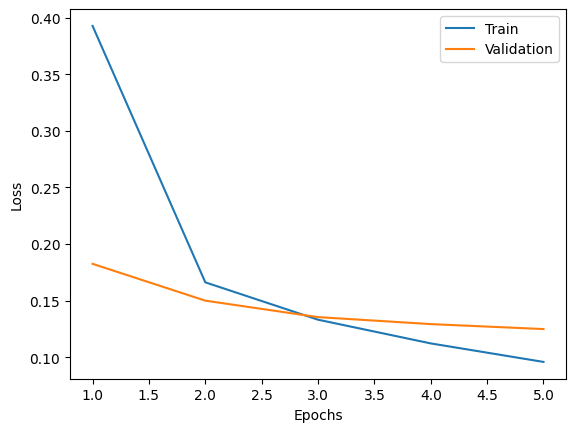

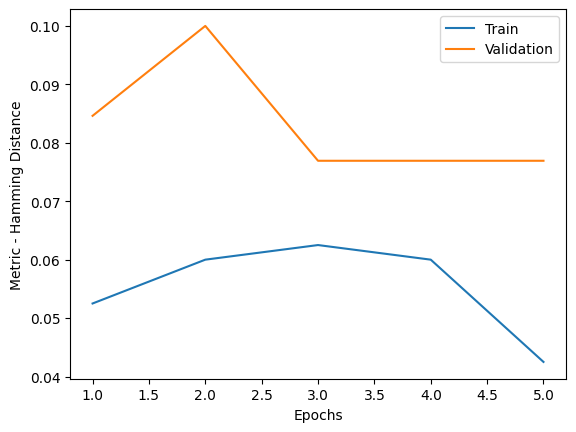

In [38]:
plot_history(train_losses, train_ham, valid_losses, valid_ham)

**Model Checkpointing**

In [39]:
# Get the current timestamp in the format "YYYY-MM-DD_HH-MM-SS"
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Define a suffix for the file name
suffix = 'twolayer'

# Combine the timestamp and suffix to create the file path
path = model_folder / f'{timestamp}_{suffix}.pt'
path

PosixPath('/content/drive/MyDrive/data/models/nlp_spring_2024/stack_exchange/2024-03-03_22-27-16_twolayer.pt')

In [40]:
# Save the model's state dictionary to the specified file path
torch.save(model_stack.state_dict(), path)

**Evaluate model on validation dataset**


In [41]:
def get_acc_pred(data_loader, model, device):
    """
    Function to get predictions and accuracy for a given data using a trained model
    Input: data iterator, model, device
    Output: predictions and accuracy for the given dataset
    """
    model = model.to(device)
    # Set model to evaluation mode
    model.eval()

    # Create empty tensors to store predictions and actual labels
    predictions = torch.Tensor().to(device)
    y = torch.Tensor().to(device)

    # Iterate over batches from data iterator
    with torch.no_grad():
        for inputs, targets in data_loader:
            # Process the batch to get the loss, outputs, and correct predictions
            _,outputs, _ = step(inputs, targets, model,
                              device, loss_function=None, optimizer=None)

            # Choose the label with maximum probability
            predicted = (outputs.data>0.5).float()

            # Add the predicted labels and actual labels to their respective tensors
            predictions = torch.cat((predictions, predicted))
            y = torch.cat((y, targets.to(device)))


    # Calculate accuracy by comparing the predicted and actual labels
    accuracy = (predictions == y).float().mean()

    # Return tuple containing predictions and accuracy
    return predictions, y, accuracy

In [42]:
# Get the prediction and accuracy for training validation
predictions_train, labels_train, acc_train = get_acc_pred(train_loader, model_stack, device)
predictions_valid, labels_valid, acc_valid = get_acc_pred(valid_loader, model_stack, device)

<ipython-input-23-dd16ae16635b>:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  labels = torch.tensor(labels, dtype=torch.float32)
<ipython-input-23-dd16ae16635b>:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  labels = torch.tensor(labels, dtype=torch.float32)
<ipython-input-23-dd16ae16635b>:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  labels = t

In [43]:
print('Train accuracy', acc_train * 100)
print('Valid accuracy', acc_valid * 100)

Train accuracy tensor(97.5977, device='cuda:0')
Valid accuracy tensor(95.4075, device='cuda:0')


In [44]:
from sklearn.metrics import multilabel_confusion_matrix

In [45]:
cm = multilabel_confusion_matrix(y_true = labels_valid.cpu().numpy(), y_pred = predictions_valid.cpu().numpy())
for i, matrix in enumerate(cm):
    print(f'Confusion matrix for class {i}:')
    print(matrix)

Confusion matrix for class 0:
[[7255  116]
 [ 564 1550]]
Confusion matrix for class 1:
[[7819   47]
 [ 325 1294]]
Confusion matrix for class 2:
[[8278   44]
 [ 475  688]]
Confusion matrix for class 3:
[[3381  644]
 [ 301 5159]]
Confusion matrix for class 4:
[[7980   23]
 [ 246 1236]]
Confusion matrix for class 5:
[[4097  360]
 [ 239 4789]]
Confusion matrix for class 6:
[[9315    5]
 [ 124   41]]
Confusion matrix for class 7:
[[9359    1]
 [ 113   12]]
Confusion matrix for class 8:
[[9424    0]
 [  61    0]]
Confusion matrix for class 9:
[[6892  122]
 [ 546 1925]]


# <Font color = 'indianred'>**9. Model Testing or Expected Performance**

In [46]:
trained_model_stack = SimpleMLP(vocab_size=Vocab_Size,
                       embedding_dim=Embed_Dim,
                       hidden_dim1=Hidden_dim1,
                       hidden_dim2=Hidden_dim2,
                       drop_prob1=0.5,
                       drop_prob2=0.5,
                       output_dim=Num_Outputs)

checkpoint = torch.load(path)
trained_model_stack.load_state_dict(checkpoint)

<All keys matched successfully>

**Evaluate Model on Test Set**

In [47]:
# Get the prediction and accuracy for test data
predictions_test, labels_test, acc_test = get_acc_pred(test_loader, trained_model_stack, device)

<ipython-input-23-dd16ae16635b>:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  labels = torch.tensor(labels, dtype=torch.float32)
<ipython-input-23-dd16ae16635b>:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  labels = torch.tensor(labels, dtype=torch.float32)
<ipython-input-23-dd16ae16635b>:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  labels = t

In [48]:
print('Valid accuracy', acc_test * 100)

Valid accuracy tensor(95.2446, device='cuda:0')


In [49]:
# test confusion matrix
cm = multilabel_confusion_matrix(y_true = labels_test.cpu().numpy(), y_pred = predictions_test.cpu().numpy())
for i, matrix in enumerate(cm):
    print(f'Confusion matrix for class {i}:')
    print(matrix)

Confusion matrix for class 0:
[[7250  113]
 [ 587 1536]]
Confusion matrix for class 1:
[[7746   54]
 [ 361 1325]]
Confusion matrix for class 2:
[[8294   40]
 [ 487  665]]
Confusion matrix for class 3:
[[3402  667]
 [ 266 5151]]
Confusion matrix for class 4:
[[7930   28]
 [ 242 1286]]
Confusion matrix for class 5:
[[4174  378]
 [ 284 4650]]
Confusion matrix for class 6:
[[9313    4]
 [ 139   30]]
Confusion matrix for class 7:
[[9354    2]
 [ 117   13]]
Confusion matrix for class 8:
[[9414    0]
 [  72    0]]
Confusion matrix for class 9:
[[6862  122]
 [ 548 1954]]


# <Font color = 'indianred'>**10. Inference**:  Make predictions on new data using trained model


In [50]:
#Inference
sample_X = X_test[0:5]

*Step 1. Preprocessing*

In [51]:
device = 'cpu'

# Convert the list of texts into a list of lists; each inner list contains the vocabulary indices for a text
list_of_list_of_indices = [tokenizer(text, stack_exchange_vocab) for text in sample_X]

# Compute the offsets for each text in the concatenated tensor
offsets = [0] + [len(i) for i in list_of_list_of_indices]
offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)

# Concatenate all text indices into a single tensor
indices = torch.cat([torch.tensor(i, dtype=torch.int64) for i in list_of_list_of_indices])

*Step 2: Get Predictions*

In [52]:
# move model to appropriate device
trained_model_stack.to(device)

# put model in evaluation mode
trained_model_stack.eval()

# get outputs (logits) from model
outputs = trained_model_stack((indices, offsets))

*Step 3: Post Processing*

In [53]:
# get predicted labels
predictions = (outputs > 0.5).float()
print(predictions)
mapping = {0: 'c#', 1: 'java', 2: 'php', 3: 'javascript', 4: 'android', 5: 'jquery', 6: 'c++', 7: 'python', 8: 'iphone', 9: 'asp.net'}

predicted_labels_names = []
for i in range(predictions.size(0)):
    labels = [mapping[j] for j in range(predictions.size(1)) if predictions[i][j] == 1]
    predicted_labels_names.append(labels)

print("Predicted labels:")
for i, labels in enumerate(predicted_labels_names):
    print(f"Sample {i+1}: {', '.join(labels)}")

tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 1.],
        [0., 1., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])
Predicted labels:
Sample 1: jquery, asp.net
Sample 2: java, android
Sample 3: javascript, jquery
Sample 4: javascript, jquery
Sample 5: c#, javascript
